# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera
Created by RESHETNIKOV Ruslan

## Table of contents
* [Introduction](#introduction)
* [Business Problem](#business_problem)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

# Introduction<a name="introduction"></a>

In such a large and multicultural city like Toronto, it is very difficult to choose a place to open a restaurant. People have different preferences. The level of competition differs from area to area. Data Science will help us do this

# Business Problem<a name="business_problem"></a>

For an investor who would like to invest their money in the restaurant business, it may be important to know the level of competition in the area where he plans to open a restaurant. Using open data, it is possible to determine the number of restaurants per 1000 people. I will be using Toronto's public statistics. I will determine the population of the city districts. Then I will pull data from Foursquare to determine the number of restaurants. Using this data, you can determine the level of competition in each borough of Toronto. This will allow the investor to more easily decide in which district of the city to open a restaurant.

In [37]:
import numpy as np
import pandas as pd
import requests
import json
from bs4 import BeautifulSoup
import re

import folium

from scipy import ndimage 
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 
from matplotlib import pyplot as plt 
from sklearn import manifold, datasets 
from sklearn.cluster import AgglomerativeClustering 
#from sklearn.datasets.samples_generator import make_blobs 
%matplotlib inline

# Data<a name="data"></a>

Download the data from http://map.toronto.ca/wellbeing/ The downloaded file contains data about 
* the neighbourhood  
* the population 

in these neighbourhood.
The Geopsy service was used to determine the coordinates of the city's districts. Geopy is a Python client for several popular geocoding web services. Geopy makes it easy for Python developers to locate the coordinates of addresses, cities, countries, and landmarks across the globe using third-party geocoders and other data sources.

Next, we combine this data with the data that we received using the Foursquare API.

In [2]:
new_data = pd.read_csv("wellbeing_toronto.csv")

In [3]:
new_data = new_data.rename({'Neighbourhood':'Neighborhood'}, axis=1)
new_data

,Neighborhood,Neighbourhood Id,Total Population
0,West Humber-Clairville,1.0,33312.0
1,Mount Olive-Silverstone-Jamestown,2.0,32954.0
2,Thistletown-Beaumond Heights,3.0,10360.0
3,Rexdale-Kipling,4.0,10529.0
4,Elms-Old Rexdale,5.0,9456.0
...,...,...,...
135,West Hill,136.0,27392.0
136,Woburn,137.0,53485.0
137,Eglinton East,138.0,22776.0
138,Scarborough Village,139.0,16724.0


We connect to the geopsy server to determine the coordinates .

In [4]:
from geopy.geocoders import Nominatim

In [5]:
geolocator = Nominatim(user_agent="toronto_app")

lat = []
long = []
for row in new_data['Neighborhood']:
    adress = row + ', Toronto, Canada'
    addr = geolocator.geocode(adress)
    if addr is None:
        lat.append(None)
        long.append(None)
    else:
        latitude = addr.latitude
        longitude = addr.longitude  
    
    lat.append(latitude)
    long.append(longitude)

In [6]:
new_data

,Neighborhood,Neighbourhood Id,Total Population
0,West Humber-Clairville,1.0,33312.0
1,Mount Olive-Silverstone-Jamestown,2.0,32954.0
2,Thistletown-Beaumond Heights,3.0,10360.0
3,Rexdale-Kipling,4.0,10529.0
4,Elms-Old Rexdale,5.0,9456.0
...,...,...,...
135,West Hill,136.0,27392.0
136,Woburn,137.0,53485.0
137,Eglinton East,138.0,22776.0
138,Scarborough Village,139.0,16724.0


In [7]:
d = {'latitude': lat, 'longitude': long}
ll = pd.DataFrame(data=d)
ll

,latitude,longitude
0,43.722563,-79.597039
1,NaN,NaN
2,43.722563,-79.597039
3,NaN,NaN
4,43.722563,-79.597039
...,...,...
172,43.768914,-79.187291
173,43.759824,-79.225291
174,43.739465,-79.232100
175,43.743742,-79.211632


We attach two Dataframes and remove the lines containing NaN

In [8]:
nd1 = new_data.join(ll, lsuffix='_caller', rsuffix='_other')


In [9]:
nd1 = nd1.dropna()


In [10]:
nd1

,Neighborhood,Neighbourhood Id,Total Population,latitude,longitude
0,West Humber-Clairville,1.0,33312.0,43.722563,-79.597039
2,Thistletown-Beaumond Heights,3.0,10360.0,43.722563,-79.597039
4,Elms-Old Rexdale,5.0,9456.0,43.722563,-79.597039
5,Kingsview Village-The Westway,6.0,22000.0,43.722114,-79.572292
6,Willowridge-Martingrove-Richview,7.0,22156.0,43.721770,-79.552173
...,...,...,...,...,...
133,Highland Creek,134.0,12494.0,43.688322,-79.428080
134,Morningside,135.0,17455.0,43.682725,-79.438055
136,Woburn,137.0,53485.0,43.682725,-79.438055
138,Scarborough Village,139.0,16724.0,43.682725,-79.438055


We determine the coordinates of the center of Toronto for the visualization of the Folium map

In [11]:
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="Toronto_center")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [12]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(nd1['latitude'], nd1['longitude'], nd1['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

We connect to Foursquare to get the data of venue

In [13]:
CLIENT_ID = 'JSRHJIIN0TGCDER4KRZZ30CEUZY45HGQ5R343WIPUQETOWRT' # your Foursquare ID
CLIENT_SECRET = 'IS32CIVWQ2FL2YD4XJ3KUEIB3LECMCI5H2RVOCXC50FVI0LR' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [14]:
def getNearbyVenues(names, latitudes, longitudes, population, radius=500):
    
    venues_list=[]
    for name, lat, lng, pop in zip(names, latitudes, longitudes,population):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            pop,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                    'Population',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [15]:
toronto_venues = getNearbyVenues(names=nd1['Neighborhood'],
                                 latitudes=nd1['latitude'], 
                                 longitudes=nd1['longitude'],
                                population=nd1['Total Population'])

West Humber-Clairville
Thistletown-Beaumond Heights
Elms-Old Rexdale
Kingsview Village-The Westway
Willowridge-Martingrove-Richview
Edenbridge-Humber Valley
Eringate-Centennial-West Deane
Markland Wood
Etobicoke West Mall
Kingsway South
Mimico
New Toronto
Long Branch
Alderwood
Humber Summit
Pelmo Park-Humberlea
Black Creek
Glenfield-Jane Heights
Downsview-Roding-CFB
York University Heights
Rustic
Brookhaven-Amesbury
Englemount-Lawrence
Clanton Park
Westminster-Branson
Willowdale West
Lansing-Westgate
Bedford Park-Nortown
St.Andrew-Windfields
Banbury-Don Mills
Victoria Village
Flemingdon Park
Parkwoods-Donalda
Pleasant View
Hillcrest Village
Bayview Woods-Steeles
Newtonbrook East
Willowdale East
Henry Farm
Thorncliffe Park
Broadview North
Danforth-East York
Woodbine-Lumsden
Taylor-Massey
The Beaches
Woodbine Corridor
Greenwood-Coxwell
Danforth
Playter Estates-Danforth
North Riverdale
Blake-Jones
South Riverdale
Cabbagetown-South St.James Town
Regent Park
Moss Park
North St.James Town
Ch

## Methodology <a name="methodology"></a>

In this project, we will focus our efforts on finding the areas of Toronto with the fewest restaurants per 1000 residents of the district.  At the first stage, we collected the necessary data: the location and type (category) of each Toronto restaurant. We have identified all places of public catering, including such as cafeterias, pizzerias and bistros (according to the Foursquare classification). The second step in our analysis will be to calculate and study the "density of restaurants" for every 1000 people living in different areas of Toronto - we will use Folium maps to determine the Top 10 promising areas with a small density of restaurants per 1000 people. At the third and last stage, we will visualize a map of the most promising areas and within them we will create clusters of locations that meet some basic requirements.

In [16]:
toronto_venues

,Neighborhood,Population,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,West Humber-Clairville,33312.0,43.722563,-79.597039,Fortinos,43.721438,-79.596291,Grocery Store
1,West Humber-Clairville,33312.0,43.722563,-79.597039,Mandarin Buffet,43.720360,-79.594387,Chinese Restaurant
2,West Humber-Clairville,33312.0,43.722563,-79.597039,New York Fries - Woodbine Centre,43.720568,-79.599609,Restaurant
3,West Humber-Clairville,33312.0,43.722563,-79.597039,TD Canada Trust,43.719630,-79.599896,Bank
4,West Humber-Clairville,33312.0,43.722563,-79.597039,Subway,43.720448,-79.600085,Sandwich Place
...,...,...,...,...,...,...,...,...
2433,Scarborough Village,16724.0,43.682725,-79.438055,One Plus One Pizza,43.687177,-79.438758,Pizza Place
2434,Guildwood,9917.0,43.690158,-79.474998,Subway,43.690218,-79.474050,Sandwich Place
2435,Guildwood,9917.0,43.690158,-79.474998,Variety And Video,43.690105,-79.475143,Convenience Store
2436,Guildwood,9917.0,43.690158,-79.474998,Dollar Tree,43.690296,-79.474667,Discount Store


We select Venue Category containing words: Restaurant, Sandwich, Coffee, Pizza, Bar, Diner, Café, Breakfast, Pub, Cafeteria and Bistro.

In [17]:
resto = toronto_venues[toronto_venues['Venue Category'].str.contains('Restaurant|Sandwich|Coffee|Pizza|Bar|Diner|Café|Breakfast|Pub|Cafeteria|Bistro')]
resto

,Neighborhood,Population,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,West Humber-Clairville,33312.0,43.722563,-79.597039,Mandarin Buffet,43.720360,-79.594387,Chinese Restaurant
2,West Humber-Clairville,33312.0,43.722563,-79.597039,New York Fries - Woodbine Centre,43.720568,-79.599609,Restaurant
4,West Humber-Clairville,33312.0,43.722563,-79.597039,Subway,43.720448,-79.600085,Sandwich Place
7,West Humber-Clairville,33312.0,43.722563,-79.597039,Tim Hortons,43.720878,-79.600062,Coffee Shop
12,Thistletown-Beaumond Heights,10360.0,43.722563,-79.597039,Mandarin Buffet,43.720360,-79.594387,Chinese Restaurant
...,...,...,...,...,...,...,...,...
2426,Scarborough Village,16724.0,43.682725,-79.438055,Oakwood Espresso,43.686403,-79.438795,Coffee Shop
2430,Scarborough Village,16724.0,43.682725,-79.438055,Domino's Pizza,43.686784,-79.438698,Pizza Place
2433,Scarborough Village,16724.0,43.682725,-79.438055,One Plus One Pizza,43.687177,-79.438758,Pizza Place
2434,Guildwood,9917.0,43.690158,-79.474998,Subway,43.690218,-79.474050,Sandwich Place


## Analysis <a name="analysis"></a>

Let's calculate how many public catering places there are in each district of the city of Toronto.

In [18]:
z = resto.groupby('Neighborhood').count()
resto_count = z['Venue Category']
resto_count = pd.DataFrame(resto_count)

In [19]:
resto_count

,Venue Category
Neighborhood,
Agincourt South-Malvern West,39
Alderwood,9
Annex,27
Bay Street Corridor,2
Bayview Woods-Steeles,4
...,...
Woodbine Corridor,6
Woodbine-Lumsden,3
Wychwood,10


In [20]:
nd1

,Neighborhood,Neighbourhood Id,Total Population,latitude,longitude
0,West Humber-Clairville,1.0,33312.0,43.722563,-79.597039
2,Thistletown-Beaumond Heights,3.0,10360.0,43.722563,-79.597039
4,Elms-Old Rexdale,5.0,9456.0,43.722563,-79.597039
5,Kingsview Village-The Westway,6.0,22000.0,43.722114,-79.572292
6,Willowridge-Martingrove-Richview,7.0,22156.0,43.721770,-79.552173
...,...,...,...,...,...
133,Highland Creek,134.0,12494.0,43.688322,-79.428080
134,Morningside,135.0,17455.0,43.682725,-79.438055
136,Woburn,137.0,53485.0,43.682725,-79.438055
138,Scarborough Village,139.0,16724.0,43.682725,-79.438055


In [21]:
resto_count_total = resto_count.merge(nd1, how='inner', on='Neighborhood').reset_index()
resto_count_total

,index,Neighborhood,Venue Category,Neighbourhood Id,Total Population,latitude,longitude
0,0,Agincourt South-Malvern West,39,128.0,23757.0,43.706748,-79.398327
1,1,Alderwood,9,20.0,12054.0,43.650206,-79.527882
2,2,Annex,27,95.0,30526.0,43.654644,-79.369728
3,3,Bay Street Corridor,2,76.0,25797.0,43.712452,-79.312653
4,4,Bayview Woods-Steeles,4,49.0,13154.0,43.795986,-79.413090
...,...,...,...,...,...,...,...
83,83,Woodbine Corridor,6,64.0,12541.0,43.787048,-79.333714
84,84,Woodbine-Lumsden,3,60.0,7865.0,43.732658,-79.311189
85,85,Wychwood,10,94.0,14349.0,43.660706,-79.360457
86,86,Yonge-St.Clair,27,97.0,12528.0,43.654644,-79.369728


We calculate the number of restaurants for 1000 people. To do this, you need to divide the number of residents of the district by 1000 (`pop_div1000`). Then we divide the number of public catering places in the area by `pop_div1000`and get the required values `per1000`

In [22]:
resto_count_total['pop_div1000'] = resto_count_total['Total Population'].div(1000)
resto_count_total['per1000'] = resto_count_total['Venue Category'].div(resto_count_total['pop_div1000'])
resto_count_total

,index,Neighborhood,Venue Category,Neighbourhood Id,Total Population,latitude,longitude,pop_div1000,per1000
0,0,Agincourt South-Malvern West,39,128.0,23757.0,43.706748,-79.398327,23.757,1.641621
1,1,Alderwood,9,20.0,12054.0,43.650206,-79.527882,12.054,0.746640
2,2,Annex,27,95.0,30526.0,43.654644,-79.369728,30.526,0.884492
3,3,Bay Street Corridor,2,76.0,25797.0,43.712452,-79.312653,25.797,0.077528
4,4,Bayview Woods-Steeles,4,49.0,13154.0,43.795986,-79.413090,13.154,0.304090
...,...,...,...,...,...,...,...,...,...
83,83,Woodbine Corridor,6,64.0,12541.0,43.787048,-79.333714,12.541,0.478431
84,84,Woodbine-Lumsden,3,60.0,7865.0,43.732658,-79.311189,7.865,0.381437
85,85,Wychwood,10,94.0,14349.0,43.660706,-79.360457,14.349,0.696913
86,86,Yonge-St.Clair,27,97.0,12528.0,43.654644,-79.369728,12.528,2.155172


Using sorting, we get the Top 10 districts with the smallest density of restaurants per 1000 people.

In [23]:
top10 = resto_count_total.sort_values(by='per1000', ascending=True).head(10)
top10

,index,Neighborhood,Venue Category,Neighbourhood Id,Total Population,latitude,longitude,pop_div1000,per1000
46,46,Mimico,1,17.0,33964.0,43.670015,-79.521948,33.964,0.029443
13,13,Church-Yonge Corridor,1,75.0,31340.0,43.683922,-79.356942,31.340,0.031908
24,24,Flemingdon Park,1,44.0,21933.0,43.717222,-79.438291,21.933,0.045593
19,19,Downsview-Roding-CFB,2,26.0,35052.0,43.592005,-79.545365,35.052,0.057058
77,77,Westminster-Branson,2,35.0,26274.0,43.695400,-79.485495,26.274,0.076121
3,3,Bay Street Corridor,2,76.0,25797.0,43.712452,-79.312653,25.797,0.077528
23,23,Etobicoke West Mall,1,13.0,11848.0,43.670015,-79.521948,11.848,0.084402
51,51,New Toronto,1,18.0,11463.0,43.631239,-79.585434,11.463,0.087237
8,8,Black Creek,2,24.0,21737.0,43.616677,-79.496805,21.737,0.092009
45,45,Markland Wood,1,12.0,10554.0,43.695785,-79.520832,10.554,0.094751


In [24]:
print('Average number of restaurants per 1,000 people in Toronto: {}'.format(resto_count_total['per1000'].mean()))

Average number of restaurants per 1,000 people in Toronto: 0.8856235373773195


Let's build a `plot.box()` of the number of restaurants per 1000 people

<AxesSubplot:>

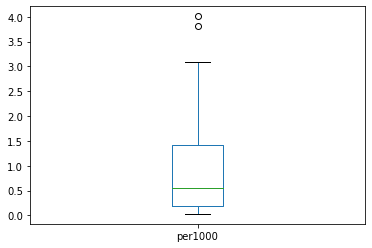

In [25]:
resto_count_total['per1000'].plot.box()

In [26]:
resto_count_total['per1000'].describe()

count    88.000000
mean      0.885624
std       0.888604
min       0.029443
25%       0.190136
50%       0.552407
75%       1.426882
max       4.011906
Name: per1000, dtype: float64

In [27]:
mean_resto = resto_count_total['per1000'].mean()

Now we will attach the Dataframe `nd1` with coordinates for further visualization on Folium maps.

In [28]:
resto_count_ll = resto_count_total.merge(nd1, how='inner', on='Neighborhood').reset_index()
resto_count_ll

,level_0,index,Neighborhood,Venue Category,Neighbourhood Id_x,Total Population_x,latitude_x,longitude_x,pop_div1000,per1000,Neighbourhood Id_y,Total Population_y,latitude_y,longitude_y
0,0,0,Agincourt South-Malvern West,39,128.0,23757.0,43.706748,-79.398327,23.757,1.641621,128.0,23757.0,43.706748,-79.398327
1,1,1,Alderwood,9,20.0,12054.0,43.650206,-79.527882,12.054,0.746640,20.0,12054.0,43.650206,-79.527882
2,2,2,Annex,27,95.0,30526.0,43.654644,-79.369728,30.526,0.884492,95.0,30526.0,43.654644,-79.369728
3,3,3,Bay Street Corridor,2,76.0,25797.0,43.712452,-79.312653,25.797,0.077528,76.0,25797.0,43.712452,-79.312653
4,4,4,Bayview Woods-Steeles,4,49.0,13154.0,43.795986,-79.413090,13.154,0.304090,49.0,13154.0,43.795986,-79.413090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,83,83,Woodbine Corridor,6,64.0,12541.0,43.787048,-79.333714,12.541,0.478431,64.0,12541.0,43.787048,-79.333714
84,84,84,Woodbine-Lumsden,3,60.0,7865.0,43.732658,-79.311189,7.865,0.381437,60.0,7865.0,43.732658,-79.311189
85,85,85,Wychwood,10,94.0,14349.0,43.660706,-79.360457,14.349,0.696913,94.0,14349.0,43.660706,-79.360457
86,86,86,Yonge-St.Clair,27,97.0,12528.0,43.654644,-79.369728,12.528,2.155172,97.0,12528.0,43.654644,-79.369728


In [29]:
resto_count_ll = resto_count_ll.drop(['index', 'Neighbourhood Id_x', 'Neighbourhood Id_y', 'Total Population_y', 'level_0'], axis=1)
resto_count_ll

,Neighborhood,Venue Category,Total Population_x,latitude_x,longitude_x,pop_div1000,per1000,latitude_y,longitude_y
0,Agincourt South-Malvern West,39,23757.0,43.706748,-79.398327,23.757,1.641621,43.706748,-79.398327
1,Alderwood,9,12054.0,43.650206,-79.527882,12.054,0.746640,43.650206,-79.527882
2,Annex,27,30526.0,43.654644,-79.369728,30.526,0.884492,43.654644,-79.369728
3,Bay Street Corridor,2,25797.0,43.712452,-79.312653,25.797,0.077528,43.712452,-79.312653
4,Bayview Woods-Steeles,4,13154.0,43.795986,-79.413090,13.154,0.304090,43.795986,-79.413090
...,...,...,...,...,...,...,...,...,...
83,Woodbine Corridor,6,12541.0,43.787048,-79.333714,12.541,0.478431,43.787048,-79.333714
84,Woodbine-Lumsden,3,7865.0,43.732658,-79.311189,7.865,0.381437,43.732658,-79.311189
85,Wychwood,10,14349.0,43.660706,-79.360457,14.349,0.696913,43.660706,-79.360457
86,Yonge-St.Clair,27,12528.0,43.654644,-79.369728,12.528,2.155172,43.654644,-79.369728


For a more correct display of the size of circles with the number of restaurants per 1000 people, we will create a new column `per1000minus`, the values in which we will calculate by subtracting from the maximum possible number of restaurants (that is, 4) the total number of restaurants `per1000`. Thus, we make an inversion of the `per1000` value.

In [30]:
resto_count_ll['per1000minus'] = 4 - resto_count_ll['per1000']

In [31]:
resto_count_ll

,Neighborhood,Venue Category,Total Population_x,latitude_x,longitude_x,pop_div1000,per1000,latitude_y,longitude_y,per1000minus
0,Agincourt South-Malvern West,39,23757.0,43.706748,-79.398327,23.757,1.641621,43.706748,-79.398327,2.358379
1,Alderwood,9,12054.0,43.650206,-79.527882,12.054,0.746640,43.650206,-79.527882,3.253360
2,Annex,27,30526.0,43.654644,-79.369728,30.526,0.884492,43.654644,-79.369728,3.115508
3,Bay Street Corridor,2,25797.0,43.712452,-79.312653,25.797,0.077528,43.712452,-79.312653,3.922472
4,Bayview Woods-Steeles,4,13154.0,43.795986,-79.413090,13.154,0.304090,43.795986,-79.413090,3.695910
...,...,...,...,...,...,...,...,...,...,...
83,Woodbine Corridor,6,12541.0,43.787048,-79.333714,12.541,0.478431,43.787048,-79.333714,3.521569
84,Woodbine-Lumsden,3,7865.0,43.732658,-79.311189,7.865,0.381437,43.732658,-79.311189,3.618563
85,Wychwood,10,14349.0,43.660706,-79.360457,14.349,0.696913,43.660706,-79.360457,3.303087
86,Yonge-St.Clair,27,12528.0,43.654644,-79.369728,12.528,2.155172,43.654644,-79.369728,1.844828


Now we will perform clustering of data on the Folium map:
* The circles of green color show areas in which the number of restaurants per 1000 people is less than the average throughout the city of Toronto. 
* The circles of red color show areas in which the number of restaurants per 1000 people is more than the average throughout the city of Toronto. 
* The radius of the circles is formed from the `per1000minus` column, that is, the larger the radius, the more attractive the area for opening a restaurant.

In [32]:
map_clusters2 = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lon, pl, reiting, reiting_minus in zip(resto_count_ll['latitude_x'], resto_count_ll['longitude_x'], resto_count_ll['Neighborhood'], 
                                 resto_count_ll['per1000'], resto_count_ll['per1000minus']):
    
    label_high = folium.Popup("Neighborhood: "+ str(pl) + "\nThe rating is above average: " + str(reiting), parse_html=True)
    label_low = folium.Popup("Neighborhood: "+ str(pl) + "\nThe rating is below average: " + str(reiting), parse_html=True) 
    if reiting < mean_resto:
        folium.CircleMarker(
        location=[lat, lon],
        radius=reiting_minus,
        popup=label_high,
        color='#00ff00',
        fill=True,
        fill_color='#00ff00',
        ).add_to(map_clusters2)

    elif reiting >= mean_resto:
        folium.CircleMarker(
        location=[lat, lon],
        radius=reiting_minus,
        popup=label_low,
        color='#ff0000',
        fill=True,
        fill_color='#ff0000',
        ).add_to(map_clusters2)
       
map_clusters2

## Hierarchical Clustering

Determine which areas of Toronto are most similar , that is, how you can group the areas, which areas are most similar to each other in terms of the number of restaurants per 100 people. Our goal here is to use clustering techniques to find the most distinctive groups of Toronto neighborhoods. This will help investors make a decision about opening a restaurant in a certain area.

In [33]:
resto_count_total

,index,Neighborhood,Venue Category,Neighbourhood Id,Total Population,latitude,longitude,pop_div1000,per1000
0,0,Agincourt South-Malvern West,39,128.0,23757.0,43.706748,-79.398327,23.757,1.641621
1,1,Alderwood,9,20.0,12054.0,43.650206,-79.527882,12.054,0.746640
2,2,Annex,27,95.0,30526.0,43.654644,-79.369728,30.526,0.884492
3,3,Bay Street Corridor,2,76.0,25797.0,43.712452,-79.312653,25.797,0.077528
4,4,Bayview Woods-Steeles,4,49.0,13154.0,43.795986,-79.413090,13.154,0.304090
...,...,...,...,...,...,...,...,...,...
83,83,Woodbine Corridor,6,64.0,12541.0,43.787048,-79.333714,12.541,0.478431
84,84,Woodbine-Lumsden,3,60.0,7865.0,43.732658,-79.311189,7.865,0.381437
85,85,Wychwood,10,94.0,14349.0,43.660706,-79.360457,14.349,0.696913
86,86,Yonge-St.Clair,27,97.0,12528.0,43.654644,-79.369728,12.528,2.155172


### Feature selection

Lets select our feature set:

In [39]:
featureset = resto_count_total[['Venue Category',  'Total Population', 'per1000']]

### Normalization

In [40]:
from sklearn.preprocessing import MinMaxScaler
x = featureset.values #returns a numpy array
min_max_scaler = MinMaxScaler()
feature_mtx = min_max_scaler.fit_transform(x)
feature_mtx [0:5]

array([[0.86363636, 0.27698693, 0.40481941],
       [0.18181818, 0.07627002, 0.18008883],
       [0.59090909, 0.39308133, 0.21470354],
       [0.02272727, 0.31197475, 0.0120743 ],
       [0.06818182, 0.09513601, 0.06896412]])

### Clustering using Scipy

In [41]:
import scipy
leng = feature_mtx.shape[0]
D = scipy.zeros([leng,leng])
for i in range(leng):
    for j in range(leng):
        D[i,j] = scipy.spatial.distance.euclidean(feature_mtx[i], feature_mtx[j])
D

<ipython-input-41-2630f2af58dc>:3: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  D = scipy.zeros([leng,leng])


array([[0.        , 0.74543084, 0.35213935, ..., 0.71882435, 0.35790916,
        0.85785393],
       [0.74543084, 0.        , 0.51857782, ..., 0.04713551, 0.54084527,
        0.31535612],
       [0.35213935, 0.51857782, 0.        , ..., 0.47798943, 0.44394758,
        0.53265049],
       ...,
       [0.71882435, 0.04713551, 0.47798943, ..., 0.        , 0.53322881,
        0.2850922 ],
       [0.35790916, 0.54084527, 0.44394758, ..., 0.53322881, 0.        ,
        0.74996195],
       [0.85785393, 0.31535612, 0.53265049, ..., 0.2850922 , 0.74996195,
        0.        ]])

In [42]:
import pylab
import scipy.cluster.hierarchy
Z = hierarchy.linkage(D, 'complete')

<ipython-input-42-8655000d21de>:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = hierarchy.linkage(D, 'complete')


In [43]:
from scipy.cluster.hierarchy import fcluster
max_d = 3
clusters = fcluster(Z, max_d, criterion='distance')
clusters

array([6, 4, 7, 5, 5, 5, 4, 7, 5, 1, 6, 7, 7, 5, 5, 7, 7, 6, 7, 5, 5, 5,
       5, 5, 5, 1, 5, 5, 5, 6, 4, 7, 7, 6, 7, 4, 5, 5, 7, 4, 1, 1, 7, 5,
       2, 5, 5, 4, 4, 1, 4, 5, 6, 4, 5, 4, 7, 7, 5, 7, 4, 7, 1, 2, 7, 4,
       5, 4, 4, 5, 5, 5, 5, 7, 5, 3, 5, 5, 7, 4, 5, 5, 2, 5, 5, 4, 6, 5],
      dtype=int32)

In [44]:
from scipy.cluster.hierarchy import fcluster
k = 5
clusters = fcluster(Z, k, criterion='maxclust')
clusters


array([4, 3, 5, 3, 3, 3, 3, 5, 3, 1, 4, 5, 5, 3, 3, 5, 5, 4, 5, 3, 3, 3,
       3, 3, 3, 1, 3, 3, 3, 4, 3, 5, 5, 4, 5, 3, 3, 3, 5, 3, 1, 1, 5, 3,
       2, 3, 3, 3, 3, 1, 3, 3, 4, 3, 3, 3, 5, 5, 3, 5, 3, 5, 1, 2, 5, 3,
       3, 3, 3, 3, 3, 3, 3, 5, 3, 2, 3, 3, 5, 3, 3, 3, 2, 3, 3, 3, 4, 3],
      dtype=int32)

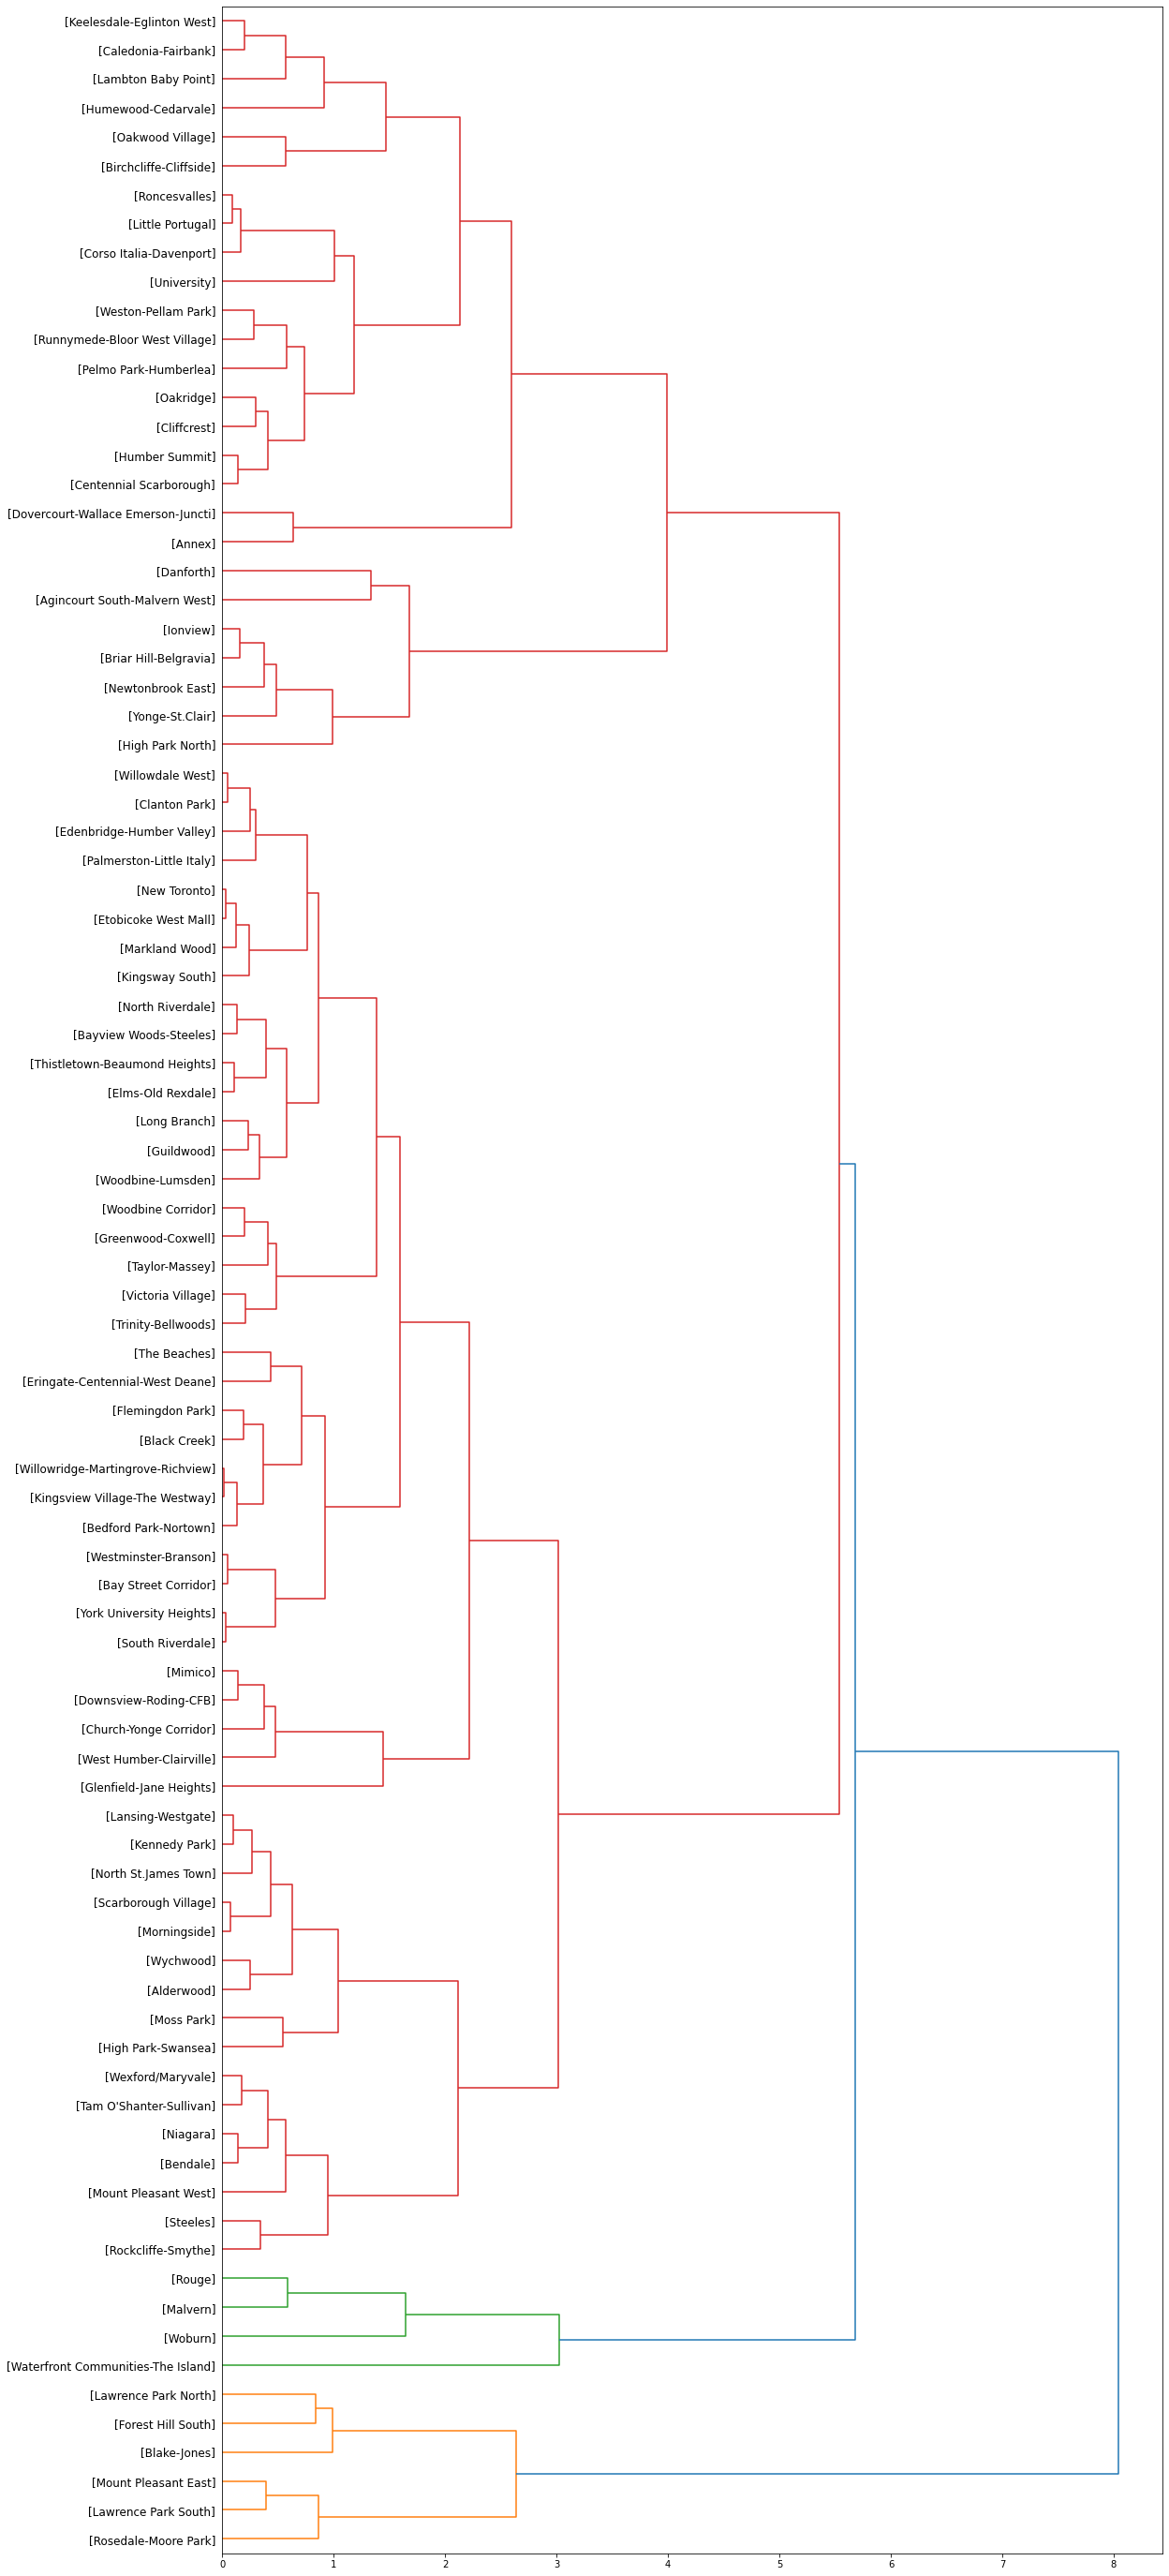

In [46]:
fig = pylab.figure(figsize=(18,50))
def llf(id):
    return '[%s]' % (resto_count_total['Neighborhood'][id])
    
dendro = hierarchy.dendrogram(Z,  leaf_label_func=llf, leaf_rotation=0, leaf_font_size =12, orientation = 'right')

## Results and Discussion <a name="results"></a>

Our analysis shows that, although Toronto has a relatively small number of restaurants for every 1000 people, there are areas with a high density of restaurants. The largest number of restaurants for every 1000 people are located in coastal areas and areas adjacent to Yonge Street. Areas remote from the coast and located on both sides of Yonge Street are of the greatest interest to investors in the restaurant business. The TOP 10 most attractive areas for opening a restaurant were determined. These are such areas as Mimico, Church-Yonge Corridor, Flemingdon Park and others.

This, of course, does not mean that these areas are actually the optimal place for a new restaurant! The purpose of this analysis was to provide information only about areas that are not crowded with existing restaurants - it is quite possible that there is a very good reason for a small number of restaurants in any of these areas,reasons why they are not suitable for a new restaurant, despite the lack of competition in this area. Therefore, the recommended zones should be considered only as a starting point for a more detailed analysis, which can eventually lead to a location where not only there are no competitors nearby, but also other factors are taken into account and all other relevant conditions are met.

## Conclusion <a name="conclusion"></a>

The aim of this project was to identify areas with the least number of restaurants per 1000 people to help investors in the restaurant business narrow down the search for the optimal place to open a new restaurant. By calculating the distribution of restaurant density based on Foursquare data, we have identified the 10 most attractive areas for investors. Clustering and visualization of districts showed areas with a high number of restaurants for every 1000 residents, in which it is not advisable to open new restaurants.